In [380]:
#import required library
import nltk
import re
import csv
import codecs
import numpy as np
import pandas as pd
from sklearn import feature_extraction
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics import (silhouette_score, confusion_matrix, classification_report,
                             accuracy_score, precision_score, recall_score)
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import scikitplot as skplt


In [381]:
#TFIDF Predictive Function
def run_tfidf_model(tfidf_model, tfidf_m, tfidf_m_test, y_train, y_test):
    tfidf_model.fit(tfidf_m, y_train)
    predictions = tfidf_model.predict(tfidf_m_test)
    accuracy = accuracy_score(predictions, y_test)
    precision = precision_score(predictions, y_test)
    recall = recall_score(predictions, y_test)
    confusion = confusion_matrix(y_test, predictions)
    print(pd.DataFrame(data = confusion, columns = ['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1']),
        "\n\nAccuracy:", accuracy, "\nPrecision:", precision, "\nRecall:", recall)

In [382]:
#Count Vectorizer Function
def run_count_model(count_model, count_m, count_m_test, y_train, y_test):
    count_model.fit(count_m, y_train)
    predictions = count_model.predict(count_m_test)
    accuracy = accuracy_score(predictions, y_test)
    precision = precision_score(predictions, y_test)
    recall = recall_score(predictions, y_test)
    confusion = confusion_matrix(y_test, predictions)
    print(pd.DataFrame(data = confusion, columns = ['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1']),
        "\n\nAccuracy:", accuracy, "\nPrecision:", precision, "\nRecall:", recall)

In [383]:
#Simple Count Vectorizer Function
def run_vec_model(vec_model, vec_m, vec_m_test, y_train, y_test):
    vec_model.fit(vec_m, y_train)
    predictions = vec_model.predict(vec_m_test)
    accuracy = accuracy_score(predictions, y_test)
    precision = precision_score(predictions, y_test)
    recall = recall_score(predictions, y_test)
    confusion = confusion_matrix(y_test, predictions)
    print(pd.DataFrame(data = confusion, columns = ['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1']),
        "\n\nAccuracy:", accuracy, "\nPrecision:", precision, "\nRecall:", recall)

In [384]:
data = pd.read_csv('movie_reviews_train_binary.csv')
data.describe()

,classification
count,1500.000000
mean,0.496667
std,0.500156
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [385]:
data.head(n=10)

,classification,text
0,0,romeo is bleeding wants to carry the unusual f...
1,0,when considering david fincher s latest film t...
2,0,weighed down by tired plot lines and spielberg...
3,0,you don t need to have seen the original speci...
4,0,the marvelous british actor derek jacobi stars...
5,0,miramax disinvited on line media from press sc...
6,0,confucius once said governing a nation is like...
7,0,susan granger s review of two can play that ga...
8,0,there was probably a good reason that the warn...
9,1,in some regards making a movie is like trying ...


In [386]:
data.shape

(1500, 2)

In [387]:
#Loads stopwords file
#stopwords = nltk.corpus.stopwords.words('english')

In [388]:
s_stem = SnowballStemmer("english")

#Function to first tokenize the sentences and then the words in the reviews.
#After the words are tokenized, they are stemmed.
def tokenize_stemming(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    created_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            created_tokens.append(token)
    created_stems = [s_stem.stem(t) for t in created_tokens]
    return created_stems

#Function to only tokenize the sentences and words in reviews so that stemmed words can be recombined if needed.
def tokenize(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    created_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            created_tokens.append(token)
    return created_tokens

In [389]:
#Creates a dictionary array to hold all processed text
text = data.text
stemmed_dict = []
tokenized_dict = []

for i in text:
    #For every word in the dataset, applies tokenize_stemming and tokenize functions
    stemmed_text = tokenize_stemming(i)
    tokenized_text = tokenize(i)
    
    #Fills the dictionary arrays with the newly created tokens or stemmed tokens
    stemmed_dict.extend(stemmed_text)
    tokenized_dict.extend(tokenized_text)

dict_f = pd.DataFrame({'words': tokenized_dict}, index = stemmed_dict)

In [390]:
dict_f.head()

,words
romeo,romeo
is,is
bleed,bleeding
want,wants
to,to


In [391]:
#TFIDF Vectorizer
tfidf_vec = TfidfVectorizer(max_df=0.8, max_features=50000,
                            stop_words='english',
                            tokenizer=tokenize_stemming,
                            ngram_range=(1,2))

tfidf_m = tfidf_vec.fit_transform(text)
tfidf_features = tfidf_vec.get_feature_names()
print(tfidf_m.shape)

(1500, 50000)


In [392]:
#Count Vectorizer
count_vec = CountVectorizer(max_df=0.8, max_features=50000,
                            stop_words='english',  
                            tokenizer=tokenize_stemming,
                            ngram_range=(1,2))

count_m = count_vec.fit_transform(text)
count_features = count_vec.get_feature_names()
count_dist = 1 - cosine_similarity(count_m)
print(count_m.shape)

(1500, 50000)


In [393]:
#K-Means clustering using TFIDF matrix
cluster_n = 2
tfidf_km = KMeans(n_clusters = cluster_n)
tfidf_km.fit_predict(tfidf_m)
clusters = tfidf_km.labels_.tolist()

In [394]:
cluster_label = tfidf_km.labels_
print(tfidf_km.fit(tfidf_m))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [395]:
print(cluster_label)

[1 0 1 ... 0 1 1]


In [396]:
tfidf_reviews = {'classification': data.classification, 'cluster': clusters}

tfidf_frame = pd.DataFrame(tfidf_reviews, index = [data.classification], columns = ['cluster'])

In [397]:
print(tfidf_frame['cluster'].value_counts())

1    993
0    507
Name: cluster, dtype: int64


In [398]:
tfidf_frame.head(n=10)

,cluster
classification,
0,1
0,0
0,1
0,0
0,1
0,0
0,1
0,1
0,1


In [399]:
print("TFIDF Vectorizer Cluster Descriptions:")
print()
#sort cluster centers by proximity to centroid
order_centroids = tfidf_km.cluster_centers_.argsort()[:, ::-1] 

for i in range(cluster_n):
    print("Cluster %d most common words:" % i)
    #print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :10]:
        print(' %s' % dict_f.loc[tfidf_features[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace

TFIDF Vectorizer Cluster Descriptions:

Cluster 0 most common words:
 b'character', b'likely', b'just', b'makes', b'time', b'scene', b'plays', b'good', b'only', b'story',

Cluster 1 most common words:
 b'alien', b'actions', b'likely', b'effects', b'makes', b'character', b'story', b'time', b'just', b'scene',



In [400]:
print(tfidf_m.shape)

(1500, 50000)


In [401]:
print(cluster_label)

[1 0 1 ... 0 1 1]


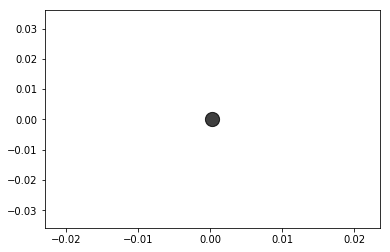

In [402]:
centers = tfidf_km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [403]:
print(confusion_matrix(data.classification, clusters))
print(classification_report(data.classification, clusters))

[[313 442]
 [194 551]]
             precision    recall  f1-score   support

          0       0.62      0.41      0.50       755
          1       0.55      0.74      0.63       745

avg / total       0.59      0.58      0.56      1500



In [404]:
print(silhouette_score(tfidf_m, data.classification, sample_size = 200))

0.000703108043035591


In [405]:
tfidf_dist = 1 - cosine_similarity(tfidf_m)

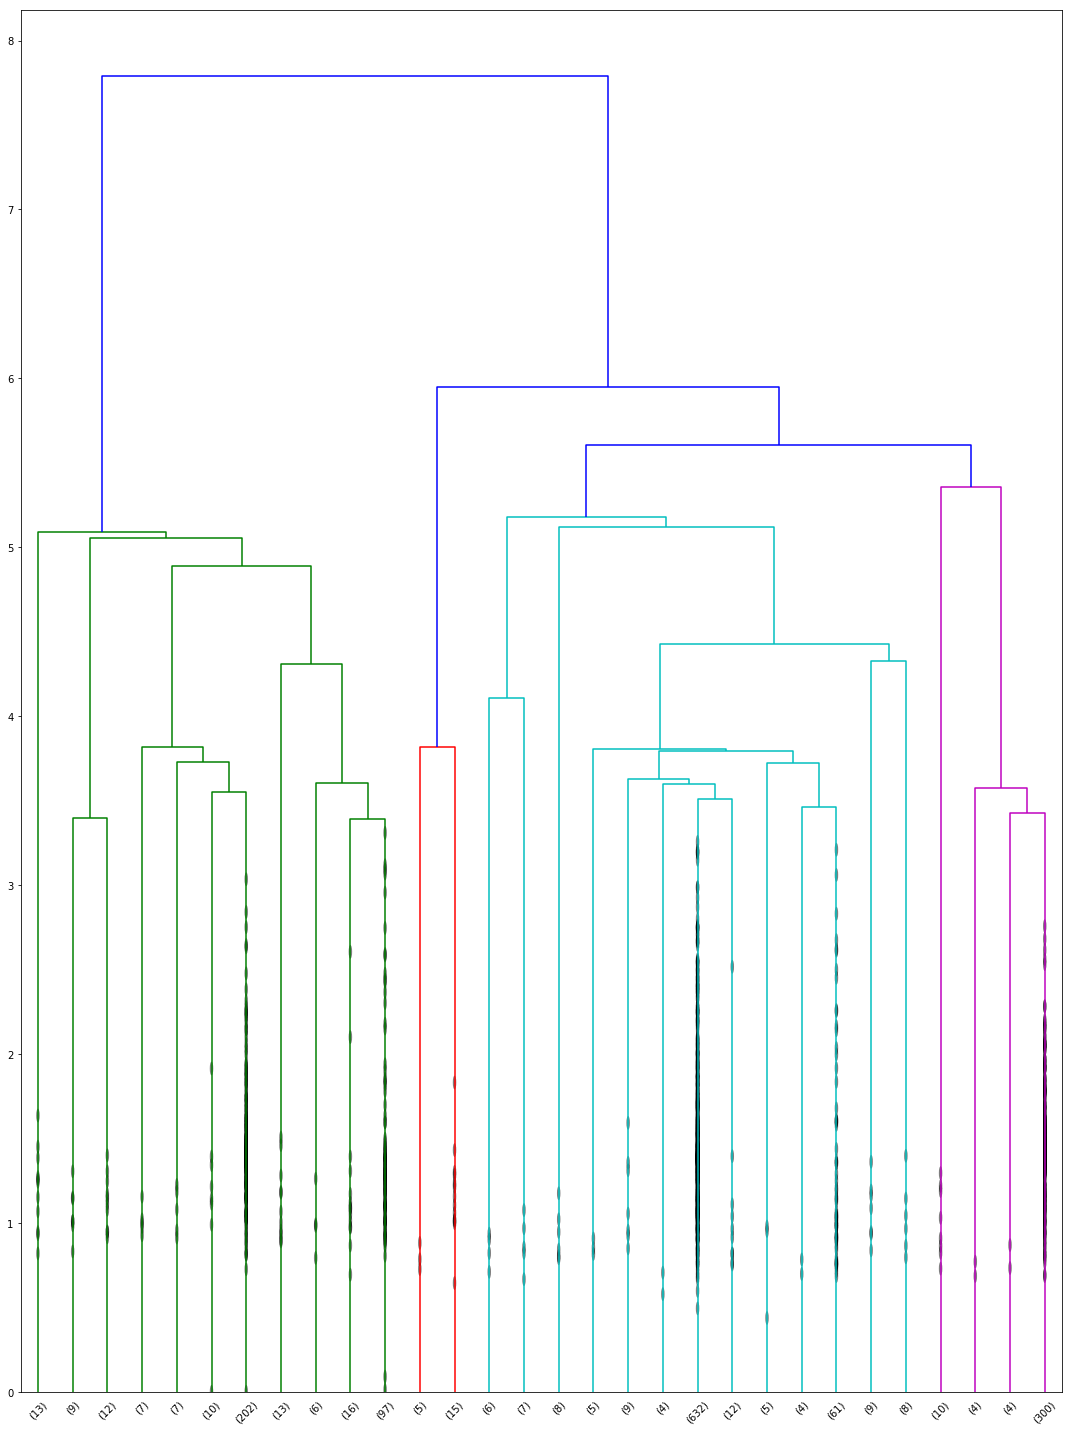

In [406]:
linkage_matrix = ward(tfidf_dist) 

fig, ax = plt.subplots(figsize=(15, 20))
ax = dendrogram(linkage_matrix, p=30, truncate_mode='lastp', orientation="top", labels=data.classification, show_contracted=True);

plt.tight_layout() 


In [407]:
#K-Means clustering using Count matrix
count_cluster_n = 2
count_km = KMeans(n_clusters = count_cluster_n)
count_km.fit_predict(count_m)
count_clusters = count_km.labels_.tolist()

In [408]:
count_reviews = {'classification': data.classification, 'count_cluster': count_clusters}

count_frame = pd.DataFrame(count_reviews, index = [data.classification], columns = ['count_cluster'])

In [409]:
print(count_frame['count_cluster'].value_counts())

1    1139
0     361
Name: count_cluster, dtype: int64


In [410]:
count_frame.head(n=10)

,count_cluster
classification,
0,1
0,0
0,0
0,1
0,1
0,1
0,1
0,1
0,1


Count Vectorizer Cluster Descriptions:

Cluster 0 most common words:
 b'likely', b'character', b'makes', b'just', b'time', b'scene', b'good', b'only', b'plays', b'story',

Cluster 1 most common words:
 b'likely', b'character', b'makes', b'time', b'just', b'only', b'scene', b'plays', b'story', b'good',



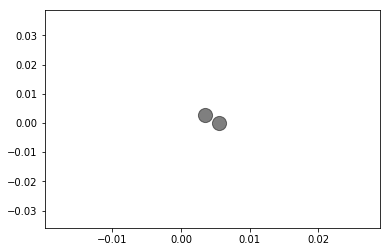

In [411]:
print("Count Vectorizer Cluster Descriptions:")
print()
#sort cluster centers by proximity to centroid
count_order_centroids = count_km.cluster_centers_.argsort()[:, ::-1] 

for j in range(count_cluster_n):
    print("Cluster %d most common words:" % j)
    #print("Cluster %d words:" % i, end='')
    
    for ind in count_order_centroids[j, :10]:
        print(' %s' % dict_f.loc[count_features[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
centers = count_km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [412]:
print(confusion_matrix(data.classification, count_clusters))
print(classification_report(data.classification, count_clusters))

[[167 588]
 [194 551]]
             precision    recall  f1-score   support

          0       0.46      0.22      0.30       755
          1       0.48      0.74      0.58       745

avg / total       0.47      0.48      0.44      1500



In [413]:
print(silhouette_score(count_m, data.classification, sample_size = 200))

-0.00024094571295467547


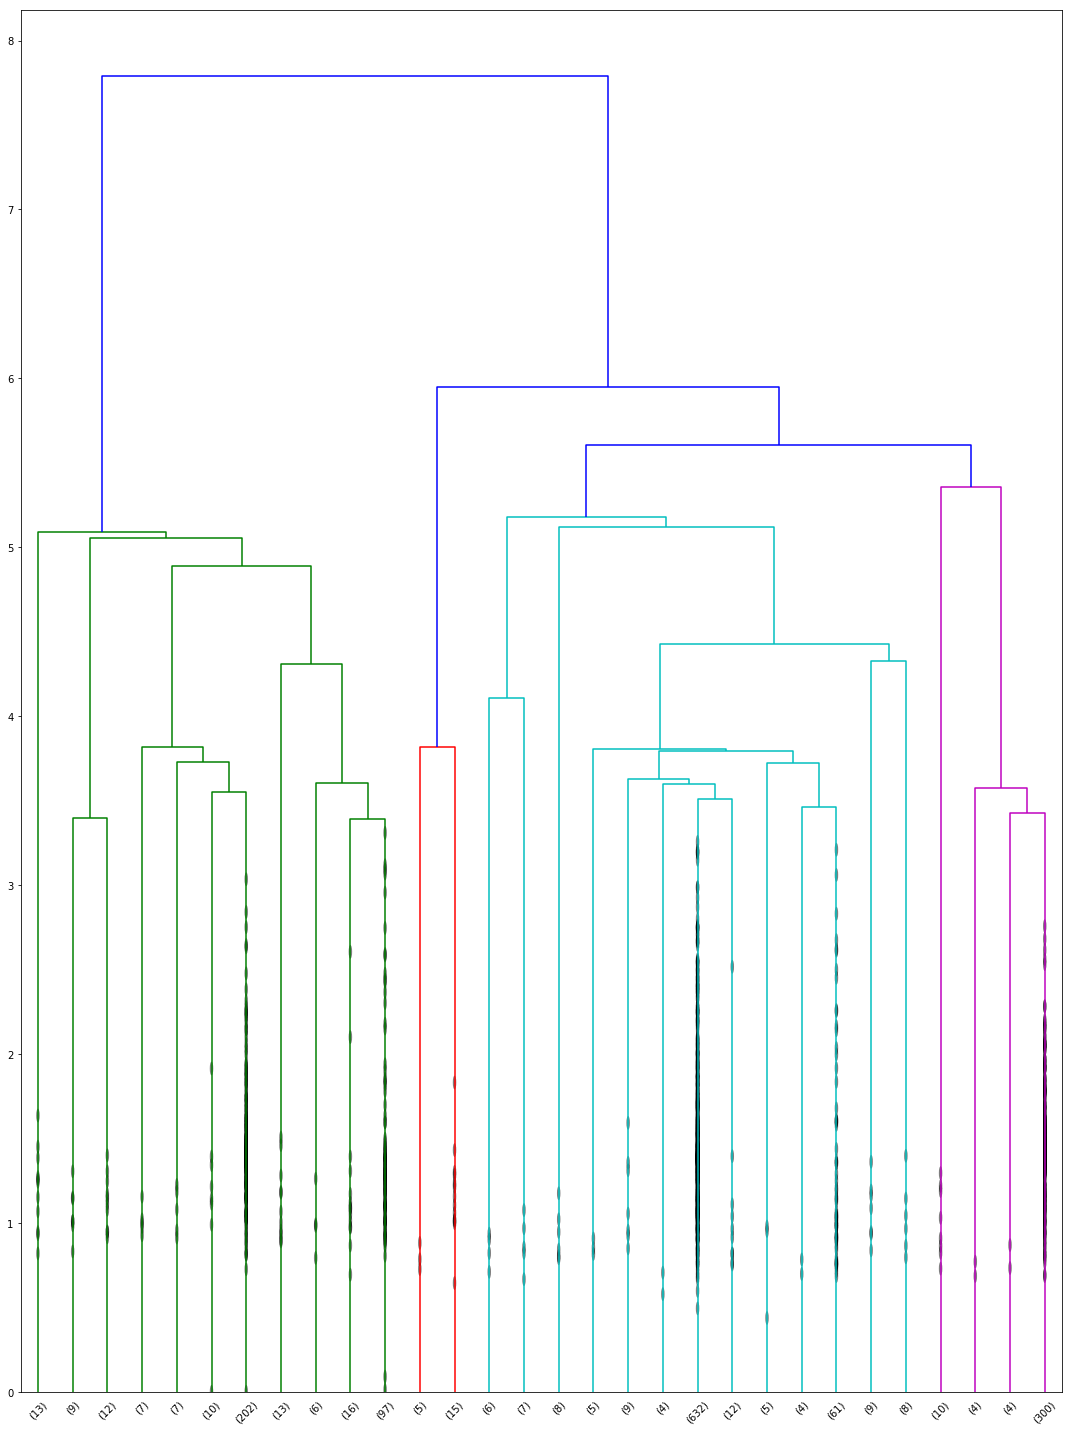

In [414]:
count_linkage_matrix = ward(count_dist) 

fig, ax = plt.subplots(figsize=(15, 20))
ax = dendrogram(linkage_matrix, p=30, truncate_mode='lastp', orientation="top", labels=data.classification, show_contracted=True);

plt.tight_layout() #show plot with tight layout

In [415]:
test_data = pd.read_csv('movie_reviews_test_binary.csv')

In [416]:
y_train = data.classification
y_test = test_data.classification
x_test = test_data.text

In [417]:
#TFIDF Vectorizing for data_test
tfidf_m_test = tfidf_vec.transform(x_test)
tfidf_features_test = tfidf_vec.get_feature_names()
print(tfidf_m_test.shape)

(500, 50000)


In [418]:
#Count Vectorizing for data_test
count_m_test = count_vec.fit_transform(x_test)
count_features_test = count_vec.get_feature_names()
print(count_m_test.shape)

(500, 50000)


In [419]:
with open("movie_reviews_train_binary_swap.csv", 'r') as vec_data:
  vec_text = list(csv.reader(vec_data))

In [420]:
print(len(vec_text))

1500


In [421]:
with open("movie_reviews_test_binary_swap.csv", 'r') as vec_test_data:
  test_text = list(csv.reader(vec_test_data))
y_train = data.classification
y_test = test_data.classification

In [422]:
#Simple Count Vectorizer
vec = CountVectorizer()
vec_m = vec.fit_transform([str(r[0]) for r in vec_text])
vec_m_test = vec.transform([str(r[0]) for r in test_text])

          Predicted 0  Predicted 1
Actual 0          201           44
Actual 1           53          202 

Accuracy: 0.806 
Precision: 0.792156862745098 
Recall: 0.8211382113821138


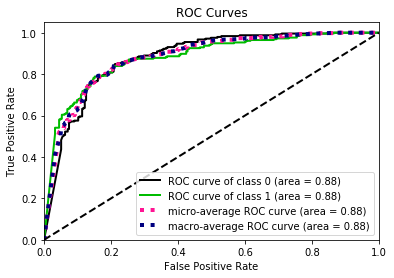

In [423]:
#Simple Count Vectorizer Multinomial Naive Bayes
vec_nb = MultinomialNB()
run_vec_model(
    vec_nb,
    vec_m,
    vec_m_test,
    y_train,
    y_test)
probas = vec_nb.predict_proba(vec_m_test)
skplt.metrics.plot_roc_curve(y_test, probas)
plt.show()

In [424]:
#Simple Count Vectorizer Linear Support Vector
vec_svc = LinearSVC()
run_vec_model(
    vec_svc,
    vec_m,
    vec_m_test,
    y_train,
    y_test)

          Predicted 0  Predicted 1
Actual 0          213           32
Actual 1           43          212 

Accuracy: 0.85 
Precision: 0.8313725490196079 
Recall: 0.8688524590163934


          Predicted 0  Predicted 1
Actual 0          190           55
Actual 1          107          148 

Accuracy: 0.676 
Precision: 0.5803921568627451 
Recall: 0.729064039408867


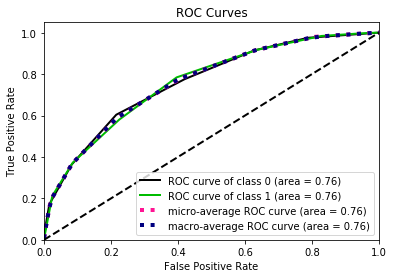

In [425]:
#Simple Count Vectorizer Ensemble Random Forest Classifier
vec_rf_class = RandomForestClassifier()
run_vec_model(
    vec_rf_class,
    vec_m,
    vec_m_test,
    y_train,
    y_test)
probas = vec_rf_class.predict_proba(vec_m_test)
skplt.metrics.plot_roc_curve(y_test, probas)
plt.show()

          Predicted 0  Predicted 1
Actual 0          204           41
Actual 1           52          203 

Accuracy: 0.814 
Precision: 0.796078431372549 
Recall: 0.8319672131147541


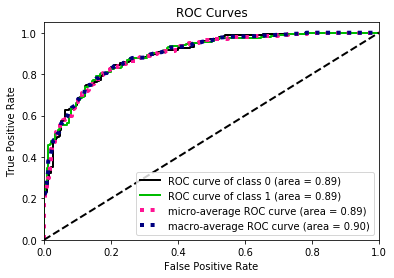

In [426]:
#TFIDF Vectorizer Multinomial Naive Bayes
tfidf_nb = MultinomialNB()
run_tfidf_model(
    tfidf_nb,
    tfidf_m,
    tfidf_m_test,
    y_train,
    y_test)
probas = tfidf_nb.predict_proba(tfidf_m_test)
skplt.metrics.plot_roc_curve(y_test, probas)
plt.show()

In [427]:
#TFIDF Vectorizer Linear Support Vector
tfidf_svc = LinearSVC()
run_tfidf_model(
    tfidf_svc,
    tfidf_m,
    tfidf_m_test,
    y_train,
    y_test)

          Predicted 0  Predicted 1
Actual 0          210           35
Actual 1           39          216 

Accuracy: 0.852 
Precision: 0.8470588235294118 
Recall: 0.8605577689243028


          Predicted 0  Predicted 1
Actual 0          202           43
Actual 1          112          143 

Accuracy: 0.69 
Precision: 0.5607843137254902 
Recall: 0.7688172043010753


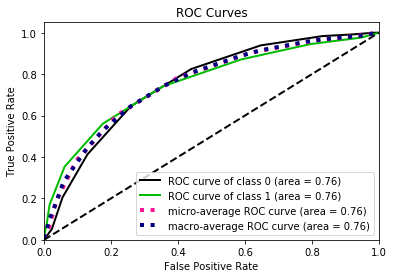

In [428]:
#TFIDF Vectorizer Ensemble Random Forest Classifier
tfidf_rf_class = RandomForestClassifier()
run_tfidf_model(
    tfidf_rf_class,
    tfidf_m,
    tfidf_m_test,
    y_train,
    y_test)
probas = tfidf_rf_class.predict_proba(tfidf_m_test)
skplt.metrics.plot_roc_curve(y_test, probas)
plt.show()

          Predicted 0  Predicted 1
Actual 0          133          112
Actual 1          146          109 

Accuracy: 0.484 
Precision: 0.42745098039215684 
Recall: 0.49321266968325794


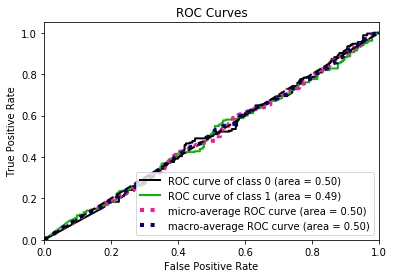

In [429]:
#Count Vectorizer Multinomial Naive Bayes
count_nb = MultinomialNB()
run_count_model(
    count_nb,
    count_m,
    count_m_test,
    y_train,
    y_test)
probas = count_nb.predict_proba(count_m_test)
skplt.metrics.plot_roc_curve(y_test, probas)
plt.show()

In [430]:
#Count Vectorizer Linear Support Vector
count_svc = LinearSVC()
run_count_model(
    count_svc,
    count_m,
    count_m_test,
    y_train,
    y_test)

          Predicted 0  Predicted 1
Actual 0          175           70
Actual 1          193           62 

Accuracy: 0.474 
Precision: 0.24313725490196078 
Recall: 0.4696969696969697


          Predicted 0  Predicted 1
Actual 0          233           12
Actual 1          237           18 

Accuracy: 0.502 
Precision: 0.07058823529411765 
Recall: 0.6


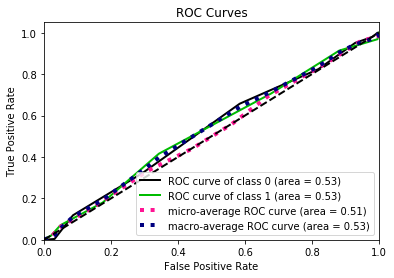

In [431]:
#Count Vectorizer Ensemble Random Forest Classifier
count_rf_class = RandomForestClassifier()
run_count_model(
    count_rf_class,
    count_m,
    count_m_test,
    y_train,
    y_test)
probas = count_rf_class.predict_proba(count_m_test)
skplt.metrics.plot_roc_curve(y_test, probas)
plt.show()